# Approximate q-learning (10 pts)

In this notebook you will teach a __PyTorch__ neural network to do Q-learning.

In [2]:
import gymnasium as gym
import thousand
from thousand.Player import Player
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from typing import Any
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [24]:
# device = torch.device("mps")
device = torch.device("cpu")

In [26]:
class SmallestPlayer(Player):

    def make_a_move(self, observation, info):
        return info['correct_moves'][0]


class BiggestPlayer(Player):

    def make_a_move(self, observation, info):
        return info['correct_moves'][-1]


class RandomPlayer(Player):

    def __init__(self, seed=None) -> None:
        self.rng: np.random.Generator = np.random.default_rng(seed)

    def make_a_move(self, observation, info):
        return self.rng.choice(info['correct_moves'])

In [27]:
def get_action(env: gym.Env, network, observation, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    observation = torch.tensor(observation, dtype=torch.float32, device=device)
    q_values = network(observation)
    if np.random.random() < epsilon:
        return int(np.random.choice(env.action_space.n))
    return torch.argmax(q_values).item()
    # return int(np.argmax(q_values.detach().numpy()))

In [28]:
def compute_td_loss(network, states, actions, rewards, next_states, is_done, gamma=0.99):
    """ Compute td loss using torch operations only. Use the formula above. """
    states = torch.tensor(
        states, dtype=torch.float32, device=device)    # shape: [batch_size, state_size]
    actions = torch.tensor(actions, dtype=torch.long, device=device)    # shape: [batch_size]
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)  # shape: [batch_size]
    # shape: [batch_size, state_size]
    next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
    is_done = torch.tensor(is_done, dtype=torch.uint8, device=device)  # shape: [batch_size]

    # get q-values for all actions in current states
    predicted_qvalues = network(states)

    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[
      range(states.shape[0]), actions
    ]
    # compute q-values for all actions in next states
    predicted_next_qvalues = network(next_states)

    # compute V*(next_states) using predicted next q-values
    next_state_values = torch.amax(predicted_next_qvalues, axis=1)
    assert next_state_values.dtype == torch.float32

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    target_qvalues_for_actions = rewards + gamma * next_state_values

    # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    target_qvalues_for_actions = torch.where(
        is_done, rewards, target_qvalues_for_actions)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)


    return loss

### Playing the game

In [29]:
def generate_session(env, options: dict[str, Any], network, optimizer, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    observation, info = env.reset(options=options)
    is_done = False

    while not is_done:    
        action = get_action(env, network, observation, epsilon=epsilon)
        next_observation, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        if train:
            optimizer.zero_grad()
            compute_td_loss(network, [observation], [action], [reward], [next_observation], [is_done]).backward()
            optimizer.step()

        total_reward += reward
        observation = next_observation

    return observation, action, reward, next_observation, is_done, total_reward

In [37]:
def learn_game(env: gym.Env, options: dict[str, Any], network, optimizer, n_sessions: int, epsilon: float, n_games: int):
    tr = trange(n_games, desc='mean: 0000; epsl: 0000')
    means = []
    for _ in tr:
        session = [generate_session(env, options, network, optimizer, epsilon, train=True) for _ in range(n_sessions)]
        observations, actions, rewards, next_observations, is_dones, total_rewards = zip(*session)
        

        optimizer.zero_grad()
        compute_td_loss(network, observations, actions, rewards, next_observations, is_dones).backward()
        optimizer.step()


        epsilon = max(epsilon * 0.99, 0.1)
        tr.set_description(
            f'mean: {np.mean(total_rewards):4.1f}; epsl: {epsilon:4.3f}')
        means.append(np.mean(total_rewards))

    return means

In [31]:
def make_chart(mean, name):
    fig, ax = plt.subplots()
    ax.set_title('mean rewards')
    ax.grid()
    ax.plot(mean, label='mean')
    ax.legend()
    fig.savefig(name)

In [47]:
env = gym.make("Thousand-v1")
network = nn.Sequential(nn.Linear(env.observation_space.shape[0], 101, device=device), 
                        nn.ReLU(),
                        nn.Linear(101, 50, device=device),
                        nn.ReLU(),
                        nn.Linear(50, env.action_space.n, device=device))
opt = torch.optim.Adam(network.parameters(), lr=1e-4)

In [42]:
all_mean = []

In [43]:
mean = learn_game(env, {'players': [RandomPlayer(), RandomPlayer()]}, network, opt, 200, 0.7, 1000)
all_mean += mean

mean: 44.4; epsl: 0.100: 100%|██████████| 1000/1000 [56:39<00:00,  3.40s/it]   


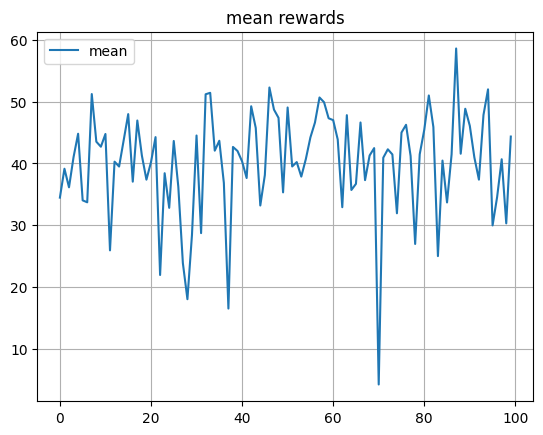

In [51]:
make_chart(all_mean[-100:], f'{time.time()}.svg')

In [45]:
second_run = []

In [48]:
mean = learn_game(env, {'players': [BiggestPlayer(), BiggestPlayer()]}, network, opt, 200, 0.7, 1000)
second_run += mean

mean: 59.7; epsl: 0.100: 100%|██████████| 1000/1000 [44:00<00:00,  2.64s/it]  


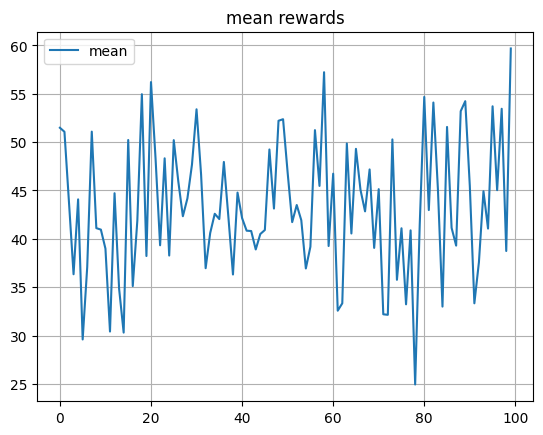

In [50]:
make_chart(second_run[-100:], f'{time.time()}.svg')

In [66]:
network2 = nn.Sequential(nn.Linear(env.observation_space.shape[0], 101, device=device), 
                        nn.ReLU(),
                        nn.Linear(101, 50, device=device),
                        nn.ReLU(),
                        nn.Linear(50, env.action_space.n, device=device))
opt2 = torch.optim.Adam(network2.parameters(), lr=1e-4)

In [67]:
lowest = learn_game(env, {'players': [SmallestPlayer(), SmallestPlayer()]}, network2, opt2, 200, 0.7, 1000)

mean: -336.2; epsl: 0.272:   9%|▉         | 94/1000 [19:51<2:12:54,  8.80s/it]

In [53]:
import pickle

In [56]:
f1 = open(f'{time.time()}.network', 'wb')

pickle.dump(network, f1)

In [61]:
f1.close()
f1 = open('1682348023.394241.network', 'rb')

network3 = pickle.load(f1)

In [63]:
lowest = learn_game(env, {'players': [SmallestPlayer(), SmallestPlayer()]}, network2, opt2, 200, 0.1, 1000)

mean: -566.8; epsl: 0.100:   0%|          | 4/1000 [00:38<2:39:25,  9.60s/it]


KeyboardInterrupt: 